In [11]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [12]:
env = BlackjackEnv()

In [13]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))
print([i for i in Q.keys()])

[]


In [25]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """        
    def policy_fn(observation):
        action_prob = np.ones(nA)*epsilon/nA
        action_prob[np.argmax(Q[observation])] += 1-epsilon
        return action_prob
    return policy_fn

In [26]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for _i in range(num_episodes):
        observation = env.reset()
        
        done = False
        episode = []
        while not done:
            probs = policy(observation)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            new_observation, reward, done, _ = env.step(action)
            episode.append((observation, action, reward))
            observation = new_observation
        states_in_episodes = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in states_in_episodes:
            sa = (state, action)
            first_state_idx = next(i for i, x in enumerate(episode) if sa == (x[0], x[1]))
            G = sum([(discount_factor**i)*r[2] for i, r in enumerate(episode[first_state_idx:])])
            returns_count[sa] += 1
            returns_sum[sa] += G
            Q[state][action] = returns_sum[sa]/returns_count[sa]
        
        
            
    
    # Implement this!
    
    return Q, policy

In [27]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

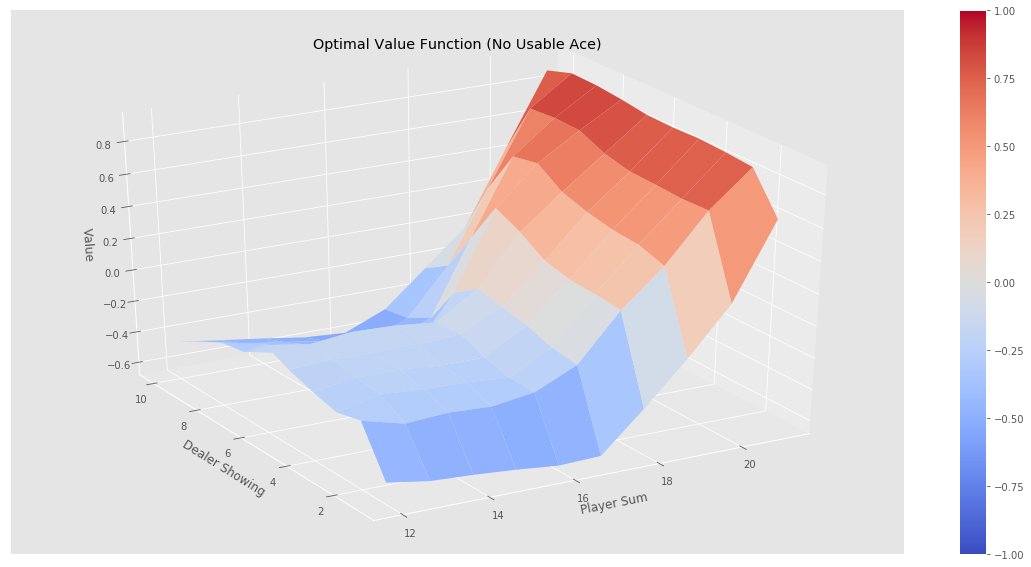

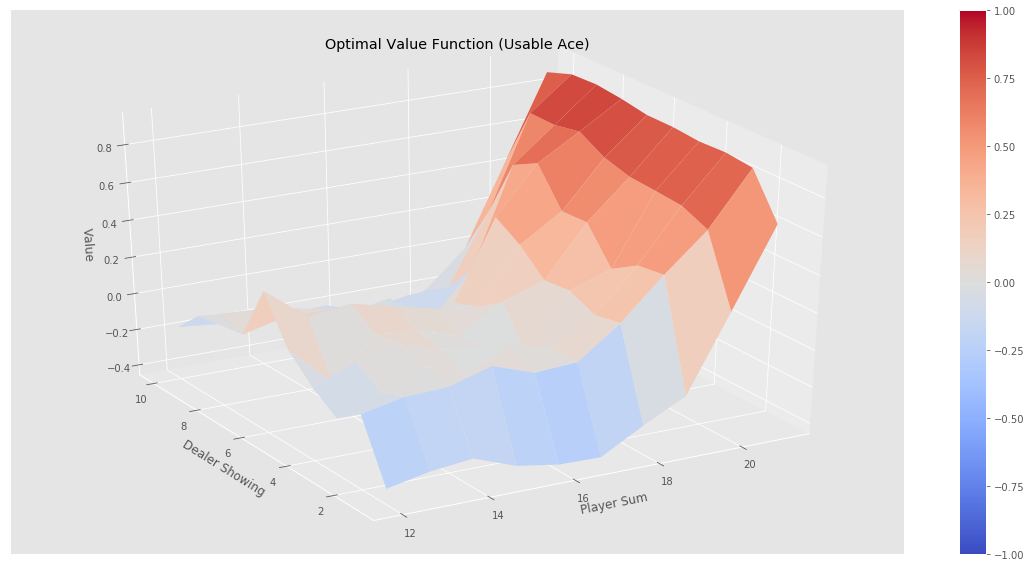

In [28]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")